# Pubmed sequential sentence classification

* Research Paper - https://arxiv.org/abs/1710.06071

## Goal - (255 - 256)

* Download a text dataset (PubMed 200K RCT)
* Write a preprocessing function for our test data
* One Hot Encoding & Label Encoding.
* Setting up multiple modelling experiments with different levels of embedding
* Building a **multimodal model** to take in different sources of data
  * Replicating the model discussed in this paper (https://arxiv.org/abs/1710.06071)
  * Actual model description (https://arxiv.org/abs/1612.05251)
* Finding the most wrong predictions
* Reference Model

![Reference Model](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/model.jpg)

## SkimLit Inputs and Outputs (257) - Ignore

## Get the data (258 - 259)

Download the dataset for pubmed 200K RCT from https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [2]:
!dir pubmed-rct

 Volume in drive C is OS
 Volume Serial Number is 30F4-96C0

 Directory of C:\2023\data-science\20-Tensorflow\07-Skimlit\pubmed-rct

04-05-2023  13:08    <DIR>          .
07-05-2023  20:21    <DIR>          ..
04-05-2023  13:08    <DIR>          PubMed_200k_RCT
04-05-2023  13:08    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
04-05-2023  13:08    <DIR>          PubMed_20k_RCT
04-05-2023  13:08    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
04-05-2023  13:08             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  397,079,023,616 bytes free


In [3]:
import os

# root data directory
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
# list of file names
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


### Preprocess Data (260)

Write a function which will read each line of the file and create the below structure:

```
[{ 'line_number' : 0,
   'target'  : 'first few characters till \t tab character',
   'text'   : 'full text after \t character till end of line character \n',
   'total_lines' : 
 },
 ...
]
```

Ignore line starting with ### and repeat the same for train_data, validation_data and test_data

In [4]:
import os

def get_lines(file_name):
    """
    Reads the file_name and returns the content of the file as list
    """
    with open(file_name) as f:
        lines = f.readlines()
    return lines

validation_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])
train_lines = get_lines(filenames[2])

print(f"size of train lines is {len(train_lines)}")
print(f"size of validation lines is {len(validation_lines)}")
print(f"size of test lines is {len(test_lines)}")

def create_data_set(lines):
    data = []
    items = []
    index = 0
    for line in lines:
        
        if line.startswith('\n'):
            for item in items:
                item['total_lines'] = index -1
                data.append(item)
            index = 0
            items = []
        else:
            tokens = line.split('\t')
        
            if len(tokens) > 1:
                item = {'line_number':index,'target': tokens[0],'text':tokens[1].strip() ,'total_lines' :index}
                items.append(item)
                index = index + 1
    return data

train_data = create_data_set(train_lines)
validation_data = create_data_set(validation_lines)
test_data = create_data_set(test_lines)

print(f"size of train data is {len(train_data)}")
print(f"size of validation data is {len(validation_data)}")
print(f"size of test data is {len(test_data)}")


size of train lines is 210040
size of validation lines is 35212
size of test lines is 35135
size of train data is 180040
size of validation data is 30212
size of test data is 30135


### Visualize Data (261)

Use pandas dataframe

head of train data
   line_number     target                                               text  \
0            0  OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
1            1    METHODS  A total of @ patients with primary knee OA wer...   
2            2    METHODS  Outcome measures included pain reduction and i...   
3            3    METHODS  Pain was assessed using the visual analog pain...   
4            4    METHODS  Secondary outcome measures included the Wester...   

   total_lines  
0           11  
1           11  
2           11  
3           11  
4           11  
unique counts of each target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


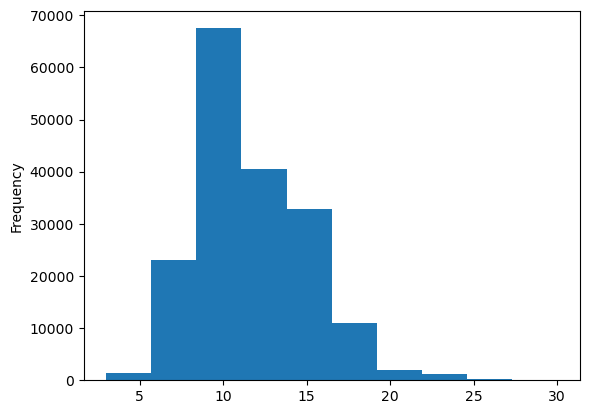

In [5]:
# Visualize data with data frame.

import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(train_data)
val_df   = pd.DataFrame(validation_data)
test_df  = pd.DataFrame(test_data)
# print the head
print('head of train data')
print(train_df.head())
print('unique counts of each target')
print(train_df['target'].value_counts())
# length of different lines
train_df.total_lines.plot.hist();


In [6]:
# convert to list
train_sentences = train_df['text'].tolist()
val_sentences   = val_df['text'].tolist()
test_sentences  = test_df['text'].tolist()
print(f"train sentences length {len(train_sentences)}")
print(f"val sentences length {len(val_sentences)}")
print(f"test sentences length {len(test_sentences)}")

train sentences length 180040
val sentences length 30212
test sentences length 30135


## One Hot Encoding & Label Encoding (262)

In [7]:
import sklearn
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf

onehot = OneHotEncoder(sparse_output=False)
train_label_one_hot = tf.constant(onehot.fit_transform(train_df['target'].to_numpy().reshape(-1,1)))
val_label_one_hot    = tf.constant(onehot.transform(val_df['target'].to_numpy().reshape(-1,1)))
test_label_one_hot   = tf.constant(onehot.transform(test_df['target'].to_numpy().reshape(-1,1)))
print('one hot encoding')
print(train_label_one_hot[0],val_label_one_hot[0],test_label_one_hot[0])

# label encoder
labelencode = LabelEncoder()
train_label_encoded = labelencode.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_encoded = labelencode.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_encoded = labelencode.transform(test_df['target'].to_numpy().reshape(-1,1))
print('label encoding...')
print(train_label_encoded[0],val_label_encoded[0],test_label_encoded[0])

print('classnames')
classnames = labelencode.classes_
print('class name = ', classnames, 'length of classes =', len(classnames))

one hot encoding
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64)
label encoding...
3 0 0
classnames
class name =  ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] length of classes = 5


C:\Users\Rupak\.conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Rupak\.conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Experiments to be Conducted (262)

![Experiments](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/experiments.jpg)

## Model 0 - Naive Bayes with TF-IDF Encoder (263)

* Selection Method
![Machine Learning Map](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/ml_map.png)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

model_0 = Pipeline([('tf-idf',TfidfVectorizer()),
               ('naive_bayes',MultinomialNB())])
model_0.fit(X=train_sentences,y=train_label_encoded)

y_pred = model_0.score(X=val_sentences,y=val_label_encoded)

val_preds = model_0.predict(val_sentences)
print('baseline model scores')
a_score = accuracy_score(y_true=val_label_encoded,y_pred=val_preds)
print('accuracy_score=',a_score)
p_score = precision_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
print('precision_score=',p_score)
recall_score = recall_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
print('recall_score=',recall_score)
f_score = f1_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
print('f1_score=',f_score)

baseline model scores
accuracy_score= 0.7218323844829869
precision_score= 0.7186466952323352
recall_score= 0.7218323844829869
f1_score= 0.6989250353450294
